# 都道府県別データ分布分析

**目的**: Train/Testデータの都道府県別分布を確認し、地理的偏りを把握する

**このノートブックで行うこと**:
1. Train/Test別の都道府県別データ数
2. 日本地図上での可視化
3. 都道府県別のターゲット統計量

## セットアップ

In [1]:
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# プロジェクトルートをパスに追加
project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root / "04_src"))
os.chdir(project_root)

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# フォント設定
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
try:
    import japanize_matplotlib
    japanize_matplotlib.japanize()
except ImportError:
    plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meiryo', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# DataLoader
from data.loader import DataLoader
from utils.config import load_config

print("✓ セットアップ完了")

✓ セットアップ完了


## 1. データ読み込み

In [2]:
# データ読み込み
data_config = load_config("data")
loader = DataLoader(data_config)

train = loader.load_train()
test = loader.load_test()

print(f"訓練データ: {train.shape}")
print(f"テストデータ: {test.shape}")

# 都道府県カラムの確認
pref_cols = [col for col in train.columns if 'addr1' in col.lower() or 'pref' in col.lower()]
print(f"\n都道府県関連カラム: {pref_cols}")

訓練データ: (363924, 149)
テストデータ: (112437, 149)

都道府県関連カラム: ['addr1_1', 'addr1_2']


## 2. 都道府県別データ数（Train/Test）

In [3]:
# 都道府県カラムを特定（addr1_1が都道府県コードと仮定）
pref_col = 'addr1_1'

if pref_col in train.columns:
    # Train
    train_pref_count = (
        train.group_by(pref_col)
        .agg(pl.len().alias('count'))
        .sort('count', descending=True)
    )
    
    # Test
    test_pref_count = (
        test.group_by(pref_col)
        .agg(pl.len().alias('count'))
        .sort('count', descending=True)
    )
    
    print("[訓練データ - 都道府県別件数（上位10件）]")
    print(train_pref_count.head(10))
    
    print("\n[テストデータ - 都道府県別件数（上位10件）]")
    print(test_pref_count.head(10))
    
    # 結合して比較
    pref_comparison = (
        train_pref_count.rename({'count': 'train_count'})
        .join(
            test_pref_count.rename({'count': 'test_count'}),
            on=pref_col,
            how='outer'
        )
        .fill_null(0)
    )
    
    print("\n[Train/Test比較]")
    print(pref_comparison.head(15))
else:
    print(f"都道府県カラム '{pref_col}' が見つかりません")

[訓練データ - 都道府県別件数（上位10件）]
shape: (10, 2)
┌─────────┬───────┐
│ addr1_1 ┆ count │
│ ---     ┆ ---   │
│ i64     ┆ u32   │
╞═════════╪═══════╡
│ 13      ┆ 66434 │
│ 27      ┆ 44752 │
│ 14      ┆ 42228 │
│ 11      ┆ 30930 │
│ 12      ┆ 23926 │
│ 28      ┆ 22778 │
│ 23      ┆ 20826 │
│ 40      ┆ 15481 │
│ 26      ┆ 13018 │
│ 22      ┆ 9544  │
└─────────┴───────┘

[テストデータ - 都道府県別件数（上位10件）]
shape: (10, 2)
┌─────────┬───────┐
│ addr1_1 ┆ count │
│ ---     ┆ ---   │
│ i64     ┆ u32   │
╞═════════╪═══════╡
│ 13      ┆ 20366 │
│ 27      ┆ 14712 │
│ 14      ┆ 11614 │
│ 11      ┆ 8811  │
│ 28      ┆ 7684  │
│ 12      ┆ 6857  │
│ 23      ┆ 6199  │
│ 40      ┆ 4796  │
│ 26      ┆ 4083  │
│ 22      ┆ 2916  │
└─────────┴───────┘

[Train/Test比較]
shape: (15, 4)
┌─────────┬─────────────┬───────────────┬────────────┐
│ addr1_1 ┆ train_count ┆ addr1_1_right ┆ test_count │
│ ---     ┆ ---         ┆ ---           ┆ ---        │
│ i64     ┆ u32         ┆ i64           ┆ u32        │
╞═════════╪═════════════╪══

## 3. 棒グラフで比較

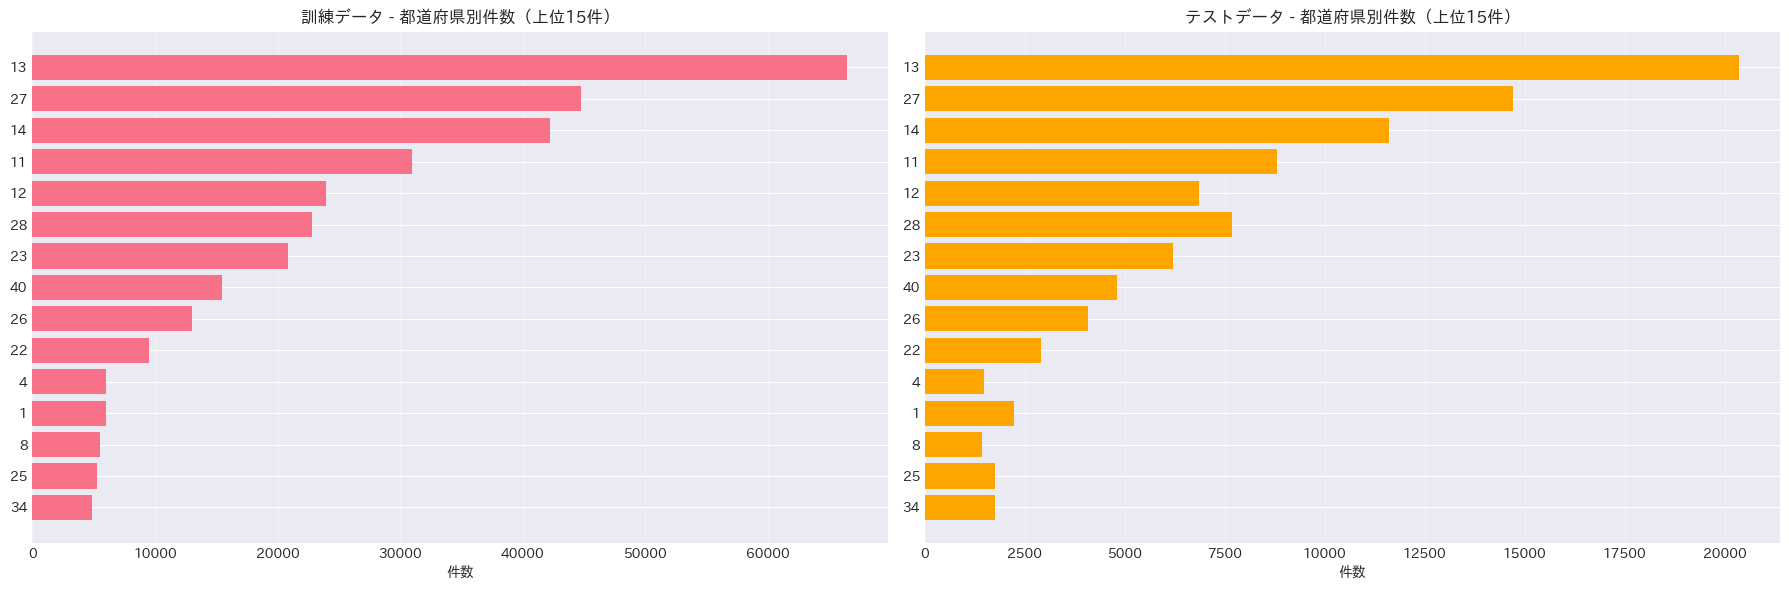

In [4]:
# 上位15都道府県で可視化
top_15 = pref_comparison.sort('train_count', descending=True).head(15)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# 訓練データ
ax1.barh(range(len(top_15)), top_15['train_count'][::-1])
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels([str(x) for x in top_15[pref_col][::-1]])
ax1.set_xlabel('件数')
ax1.set_title('訓練データ - 都道府県別件数（上位15件）')
ax1.grid(axis='x', alpha=0.3)

# テストデータ
ax2.barh(range(len(top_15)), top_15['test_count'][::-1], color='orange')
ax2.set_yticks(range(len(top_15)))
ax2.set_yticklabels([str(x) for x in top_15[pref_col][::-1]])
ax2.set_xlabel('件数')
ax2.set_title('テストデータ - 都道府県別件数（上位15件）')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 4. 日本地図上での可視化

**必要なライブラリ**: `geopandas`, `japanmap`（またはgeojsonデータ）

In [5]:
# 都道府県コードと名称のマッピング
pref_code_to_name = {
    1: '北海道', 2: '青森県', 3: '岩手県', 4: '宮城県', 5: '秋田県',
    6: '山形県', 7: '福島県', 8: '茨城県', 9: '栃木県', 10: '群馬県',
    11: '埼玉県', 12: '千葉県', 13: '東京都', 14: '神奈川県', 15: '新潟県',
    16: '富山県', 17: '石川県', 18: '福井県', 19: '山梨県', 20: '長野県',
    21: '岐阜県', 22: '静岡県', 23: '愛知県', 24: '三重県', 25: '滋賀県',
    26: '京都府', 27: '大阪府', 28: '兵庫県', 29: '奈良県', 30: '和歌山県',
    31: '鳥取県', 32: '島根県', 33: '岡山県', 34: '広島県', 35: '山口県',
    36: '徳島県', 37: '香川県', 38: '愛媛県', 39: '高知県', 40: '福岡県',
    41: '佐賀県', 42: '長崎県', 43: '熊本県', 44: '大分県', 45: '宮崎県',
    46: '鹿児島県', 47: '沖縄県'
}

# データに都道府県名を追加（replace_strictを使用）
pref_comparison_with_name = pref_comparison.with_columns(
    pl.col(pref_col).replace_strict(
        old=list(pref_code_to_name.keys()),
        new=list(pref_code_to_name.values()),
        default=None
    ).alias('pref_name')
)

print("[都道府県コード→名称マッピング完了]")
print(pref_comparison_with_name.head())

[都道府県コード→名称マッピング完了]
shape: (5, 5)
┌─────────┬─────────────┬───────────────┬────────────┬───────────┐
│ addr1_1 ┆ train_count ┆ addr1_1_right ┆ test_count ┆ pref_name │
│ ---     ┆ ---         ┆ ---           ┆ ---        ┆ ---       │
│ i64     ┆ u32         ┆ i64           ┆ u32        ┆ str       │
╞═════════╪═════════════╪═══════════════╪════════════╪═══════════╡
│ 13      ┆ 66434       ┆ 13            ┆ 20366      ┆ 東京都    │
│ 27      ┆ 44752       ┆ 27            ┆ 14712      ┆ 大阪府    │
│ 14      ┆ 42228       ┆ 14            ┆ 11614      ┆ 神奈川県  │
│ 11      ┆ 30930       ┆ 11            ┆ 8811       ┆ 埼玉県    │
│ 28      ┆ 22778       ┆ 28            ┆ 7684       ┆ 兵庫県    │
└─────────┴─────────────┴───────────────┴────────────┴───────────┘


In [6]:
# japanmapを使った簡易可視化
try:
    from japanmap import picture
    
    # 訓練データの都道府県別件数を辞書に変換
    train_dict = {}
    for row in pref_comparison.iter_rows(named=True):
        pref_code = row[pref_col]
        if pref_code in pref_code_to_name:
            train_dict[pref_code_to_name[pref_code]] = row['train_count']
    
    # 地図描画
    plt.figure(figsize=(12, 10))
    plt.imshow(picture(train_dict), cmap='YlOrRd')
    plt.title('訓練データ - 都道府県別データ数（色が濃いほど多い）', fontsize=14)
    plt.axis('off')
    plt.colorbar(shrink=0.5, label='件数')
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("japanmapがインストールされていません")
    print("インストール: pip install japanmap")
    print("\n代替として、棒グラフで可視化済みです（上記セル参照）")

japanmapがインストールされていません
インストール: pip install japanmap

代替として、棒グラフで可視化済みです（上記セル参照）


## 5. 都道府県別ターゲット統計量（Train）

[都道府県別ターゲット統計量 - 平均賃料順]
shape: (47, 6)
┌─────────┬───────┬────────────┬──────────────┬───────────┬───────────┐
│ addr1_1 ┆ count ┆ mean_price ┆ median_price ┆ std_price ┆ pref_name │
│ ---     ┆ ---   ┆ ---        ┆ ---          ┆ ---       ┆ ---       │
│ i64     ┆ u32   ┆ f64        ┆ f64          ┆ f64       ┆ str       │
╞═════════╪═══════╪════════════╪══════════════╪═══════════╪═══════════╡
│ 13      ┆ 66434 ┆ 4.0755e7   ┆ 3.48e7       ┆ 2.6019e7  ┆ 東京都    │
│ 47      ┆ 3364  ┆ 3.5364e7   ┆ 3.28e7       ┆ 1.9473e7  ┆ 沖縄県    │
│ 14      ┆ 42228 ┆ 2.8600e7   ┆ 2.59e7       ┆ 1.6433e7  ┆ 神奈川県  │
│ 26      ┆ 13018 ┆ 2.5137e7   ┆ 1.98e7       ┆ 2.0757e7  ┆ 京都府    │
│ 23      ┆ 20826 ┆ 2.4319e7   ┆ 2.18e7       ┆ 1.4469e7  ┆ 愛知県    │
│ …       ┆ …     ┆ …          ┆ …            ┆ …         ┆ …         │
│ 38      ┆ 2518  ┆ 1.5685e7   ┆ 1.449e7      ┆ 7.8344e6  ┆ 愛媛県    │
│ 37      ┆ 979   ┆ 1.5342e7   ┆ 1.38e7       ┆ 8.2544e6  ┆ 香川県    │
│ 35      ┆ 2451  ┆ 1.5119e7   ┆ 1.38e7       ┆

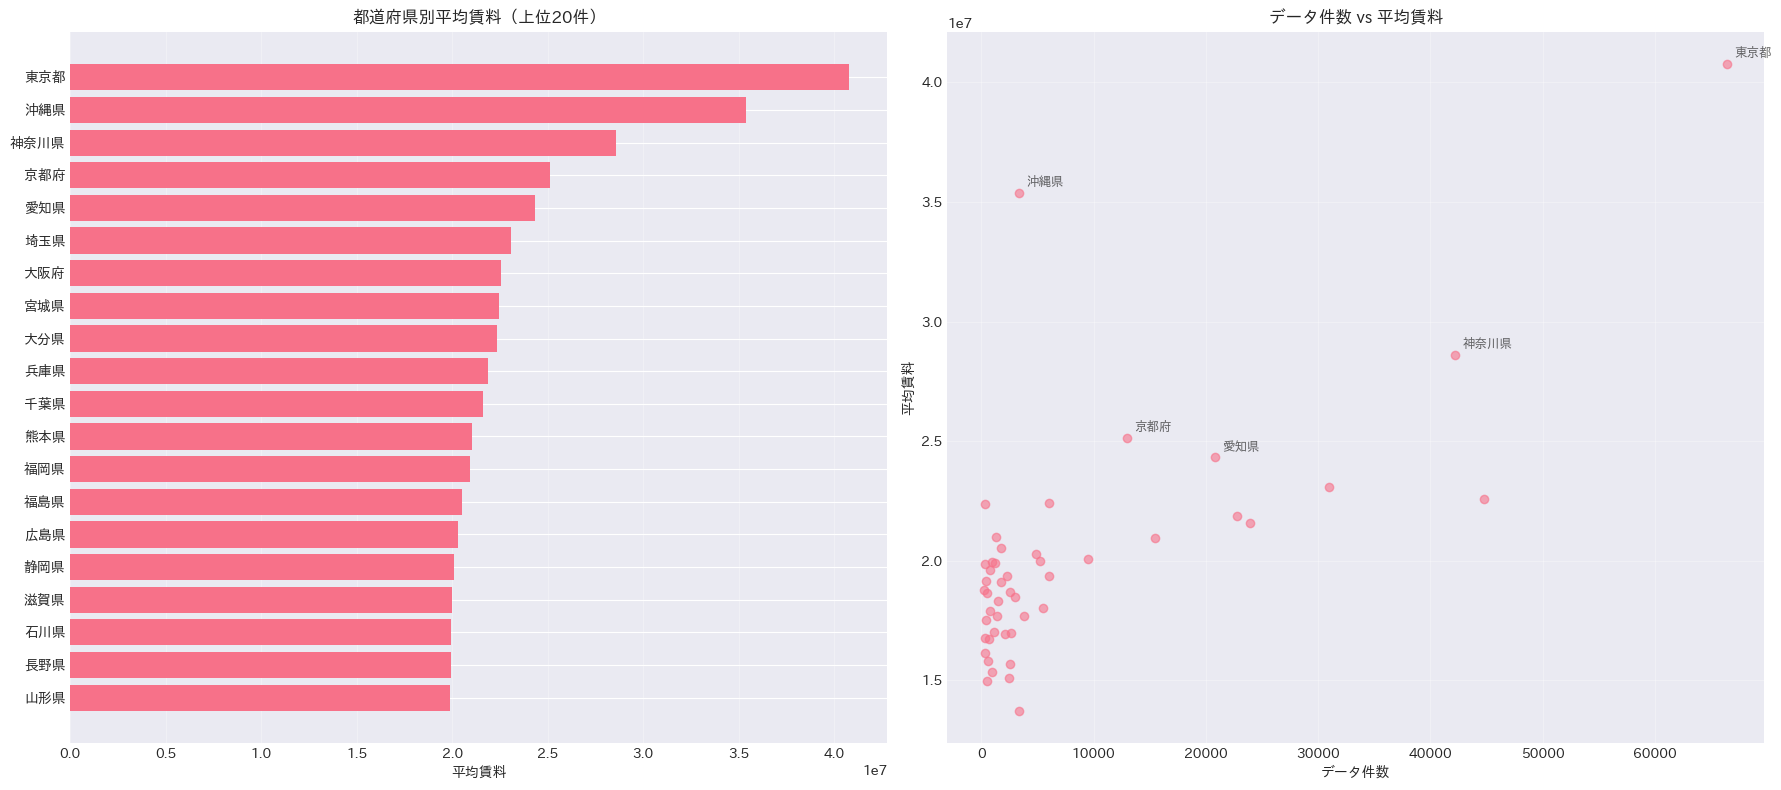

In [7]:
# ターゲット変数があればその統計量も確認
target_col = 'money_room'

if target_col in train.columns:
    pref_target_stats = (
        train.group_by(pref_col)
        .agg([
            pl.len().alias('count'),
            pl.col(target_col).mean().alias('mean_price'),
            pl.col(target_col).median().alias('median_price'),
            pl.col(target_col).std().alias('std_price')
        ])
        .sort('mean_price', descending=True)
    )
    
    # 都道府県名を追加（replace_strictを使用）
    pref_target_stats = pref_target_stats.with_columns(
        pl.col(pref_col).replace_strict(
            old=list(pref_code_to_name.keys()),
            new=list(pref_code_to_name.values()),
            default=None
        ).alias('pref_name')
    )
    
    print("[都道府県別ターゲット統計量 - 平均賃料順]")
    print(pref_target_stats)
    
    # 可視化
    top_20 = pref_target_stats.head(20)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # 平均賃料
    ax1.barh(range(len(top_20)), top_20['mean_price'][::-1])
    ax1.set_yticks(range(len(top_20)))
    ax1.set_yticklabels([str(x) for x in top_20['pref_name'][::-1]])
    ax1.set_xlabel('平均賃料')
    ax1.set_title('都道府県別平均賃料（上位20件）')
    ax1.grid(axis='x', alpha=0.3)
    
    # 件数 vs 平均賃料の散布図
    ax2.scatter(pref_target_stats['count'], pref_target_stats['mean_price'], alpha=0.6)
    ax2.set_xlabel('データ件数')
    ax2.set_ylabel('平均賃料')
    ax2.set_title('データ件数 vs 平均賃料')
    ax2.grid(alpha=0.3)
    
    # 主要都道府県にラベル
    for row in pref_target_stats.head(5).iter_rows(named=True):
        ax2.annotate(
            row['pref_name'],
            (row['count'], row['mean_price']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9,
            alpha=0.7
        )
    
    plt.tight_layout()
    plt.show()
else:
    print("ターゲット変数が見つかりません（Testデータのため）")

## 6. まとめ

### データ分布の特徴
- **データ数が多い都道府県**: [メモ]
- **データ数が少ない都道府県**: [メモ]
- **Train/Testの分布の違い**: [メモ]

### 都道府県別の賃料傾向
- **賃料が高い都道府県**: [メモ]
- **賃料が低い都道府県**: [メモ]
- **データ件数との関係**: [メモ]

### モデリングへの示唆
- [ ] 都道府県をTarget Encodingすべきか？
- [ ] データが少ない都道府県の扱い（集約するか？）
- [ ] 地域別にモデルを分けるか？